In [7]:
#import numpy as np
import autograd.numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
import seaborn as sb

# local imports
from train.dataloader import create_datasets_sim
from train.model import vgg13bn, vggSmall
from train.train import train_model

from train.GPclassification_model import GaussianProcessModel, log_lik_bernoulli, create_se_kernel, predictive

# plots setting
sb.set(font_scale=1.25)
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%reload_ext autoreload
%autoreload 2

# Predict steady state
Given $m$ observations from the quantum trajectory samples can we predict if the particle is in a steady state? We will try with different values of $m$. First we manipulate the data to get the label of steady state, with will be binery.

In [8]:
# psysical model parameters
N = 100 # NOTE: must be fixed for the CNN
g = 0.25
a0 = 1/np.sqrt(2)

# data
N_data = 1000

# ML parameters
epochs = 10 
lr = 1e-4
batch_size = 128
folds = 10


N_sim and N are equal, changing N_sim to N+1
torch.Size([101, 101])


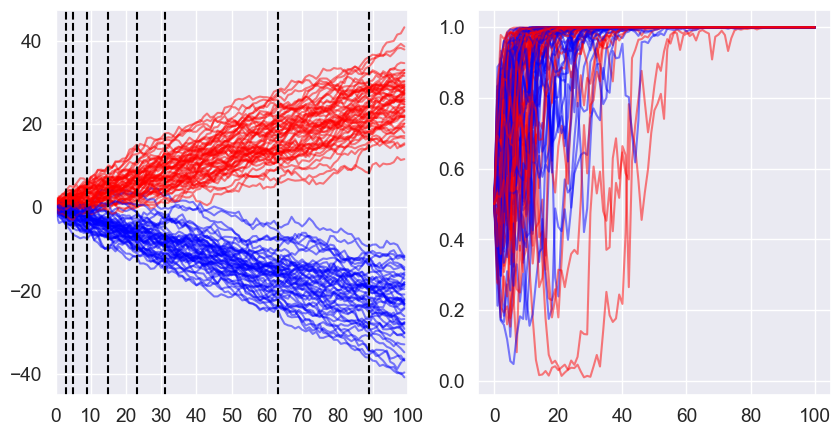

The different m values are: [90, 64, 32, 24, 16, 10, 6, 4]


In [9]:
test_dataset  =  create_datasets_sim(100,1, N=N, g=g, a0=a0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


M = [90,64, 32, 24, 16, 10, 6, 4]
# plot some examples from the dataset
Xtest, ytest, atest, btest = test_dataset.tensors
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(Xtest.shape[0]):
    X = Xtest[i].numpy()
    label = ytest[i].item()
    if label == 0:
        axes[0].plot(range(X.shape[-1]), np.cumsum(X.squeeze(0)), color='blue', alpha=0.5)
    else:
        axes[0].plot(range(X.shape[-1]), np.cumsum(X.squeeze(0)), color='red', alpha=0.5)

# vertical lines for M
for m in M:
    axes[0].axvline(m-1, color='black', linestyle='--')

axes[0].set_xlim([0, N])
axes[0].set_xticks(range(0, N+1, 10))

print(atest.shape)
# plot the a and b
for i in range(atest.shape[0]):
    label = ytest[i].item()
    if label == 1:
        axes[1].plot(range(N+1), atest[i].numpy()**2, label= 'a', color = 'blue', alpha=0.5)
    else:
        axes[1].plot(range(N+1), btest[i].numpy()**2, label= 'b', color = 'red', alpha=0.5)

plt.show()
print(f"The different m values are: {M}")




## Noiseless data

### ML model
try and predict the steady state using a simple CNN model. 

In [10]:
# train and val dataset
train_dataset, val_dataset =  create_datasets_sim(N_data,0.8, N=N, g=g, a0=a0)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

models = []
stats = []

loss_fn = torch.nn.CrossEntropyLoss()

for m in tqdm(M):
    # model
    model = model = vggSmall(num_classes=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train
    model, stat = train_model(model, train_loader, val_loader, m, epochs, loss_fn, optimizer, device , verbose=False)

    # save
    models.append(model)
    stats.append(stat)

100%|██████████| 8/8 [00:43<00:00,  5.43s/it]


plot loss curves

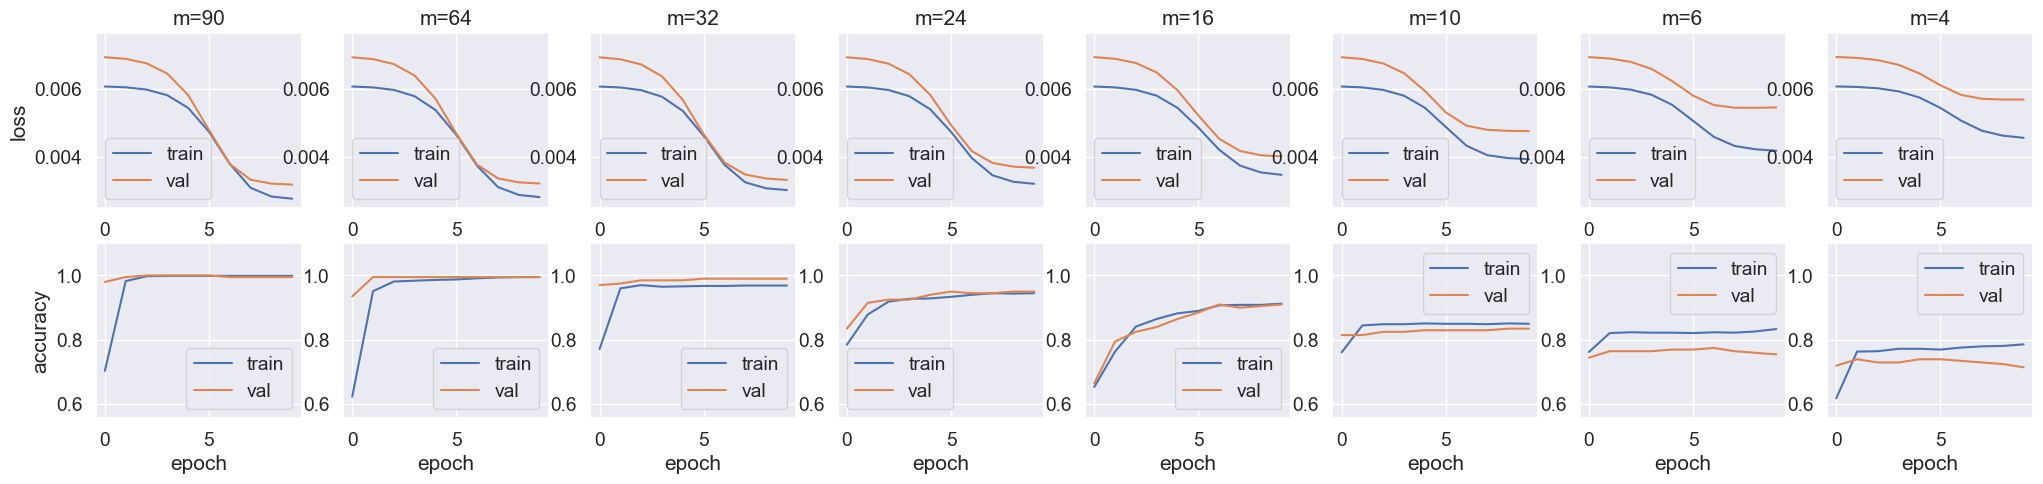

In [11]:
# overall min and max acc and losses on both train and val
min_loss = min([min(stat['train_loss']+stat['val_loss']) for stat in stats])
max_loss = max([max(stat['train_loss']+stat['val_loss']) for stat in stats])
min_acc = min([min(stat['train_acc']+stat['val_acc']) for stat in stats])
max_acc = max([max(stat['train_acc']+stat['val_acc']) for stat in stats])


fig, axes = plt.subplots(2, len(M), figsize=(25,5))

for i, stat in enumerate(stats):
    
    # set title
    axes[0,i].set_title(f"m={M[i]}")
    axes[0,i].plot(stat['train_loss'], label='train')
    axes[0,i].plot(stat['val_loss'], label='val')
    axes[0,i].legend()
    #axes[0,i].set_xlabel('epoch')
    if i == 0:
        axes[0,i].set_ylabel('loss')
    axes[0,i].set_ylim([min_loss*0.9, max_loss*1.1])
    

    axes[1,i].plot(stat['train_acc'], label='train')
    axes[1,i].plot(stat['val_acc'], label='val')
    axes[1,i].set_xlabel('epoch')
    if i==0:
        axes[1,i].set_ylabel('accuracy')
    axes[1,i].legend()
    axes[1,i].set_ylim([min_acc*0.9, max_acc*1.1])
plt.show()

### Performance on the test set
how is the performance on the test set?

In [12]:
# Get the train exact probabilities
_, _, atrain, btrain = train_dataset.tensors

find_probs = lambda a, b: np.maximum(a**2, b**2).mean(axis=0)
train_qprobs = find_probs(atrain, btrain)

# test with ensemble
test_acc = np.zeros((len(M), folds))
test_qprobs = np.zeros((N+1, folds))

all_testsets = [create_datasets_sim(200,1, N=N, g=g, a0=a0) for _ in range(folds)]

for i, model in enumerate(models):
    for j in range(folds):
        acc = 0
        test_dataset  =  all_testsets[j]
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
        _, _, atest, btest = test_dataset.tensors
        for X, y, a, b in test_loader:
            X = X[:,:,:M[i]]
            yhat = model(X)
            acc += (yhat.argmax(1) == y).float().mean().item()

        test_acc[i,j] = acc/len(test_loader)
        test_qprobs[:,j] = find_probs(atest, btest)

mean_test_acc = test_acc.mean(axis=1)


/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_59251/292496856.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_qprobs[:,j] = find_probs(atest, btest)


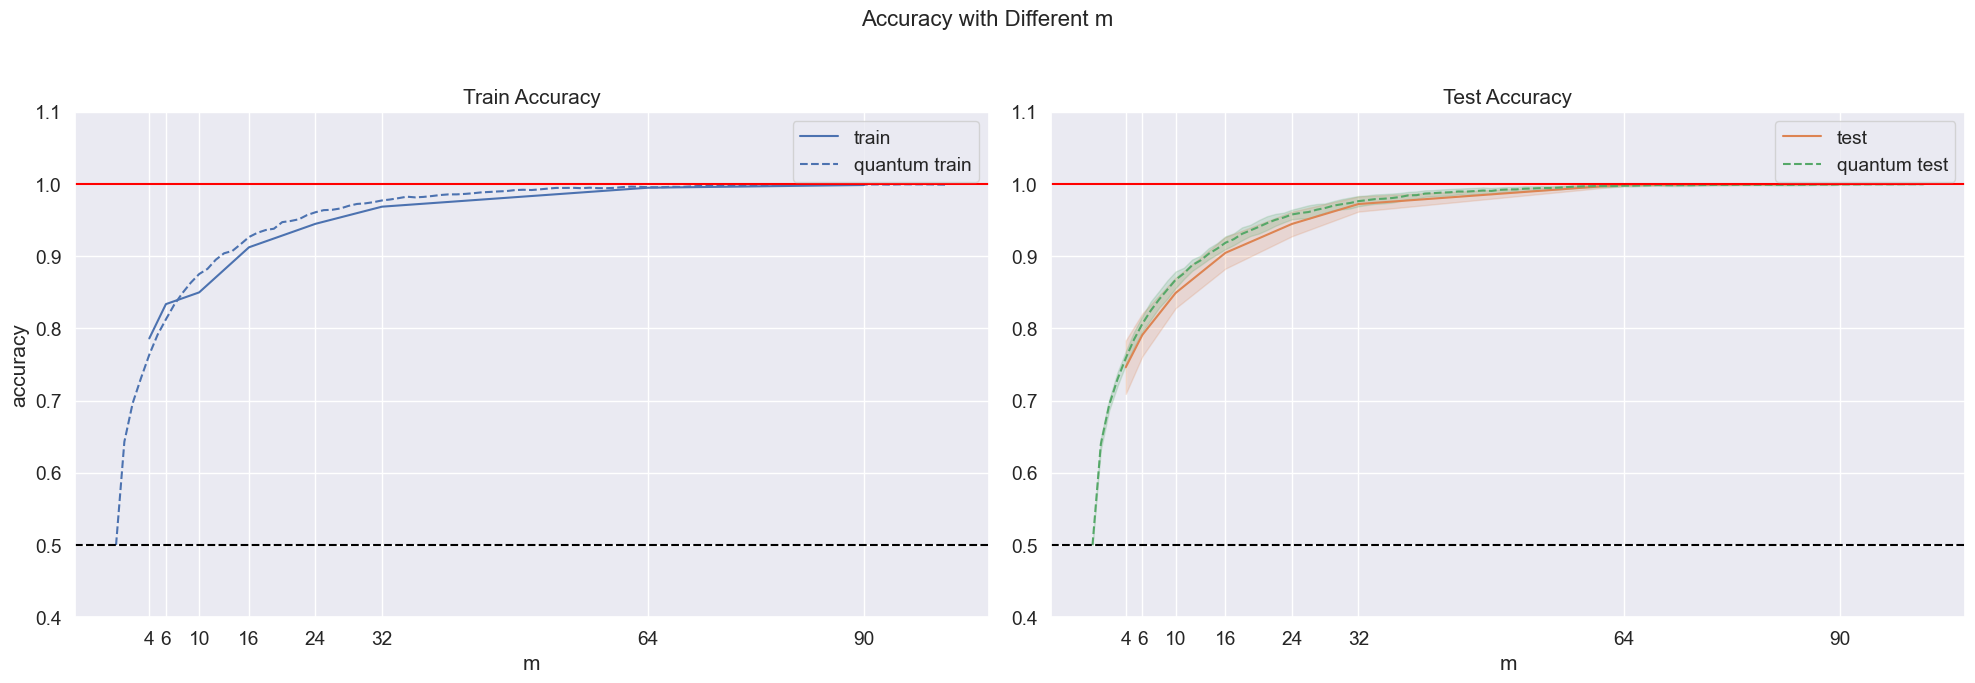

In [13]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  # 2 rows, 1 column
fig.suptitle('Accuracy with Different m', fontsize=16)

# Train Plot
axes[0].plot(M, [stat['train_acc'][-1] for stat in stats], label='train', color='C0')
axes[0].plot(range(N + 1), train_qprobs, label='quantum train', color='C0', linestyle='--')
axes[0].set_title('Train Accuracy')
axes[0].set_xlabel('m')
axes[0].set_ylabel('accuracy')
axes[0].set_ylim(0.4, 1.1)
axes[0].set_xticks(M)
axes[0].axhline(0.5, color='black', linestyle='--')
axes[0].axhline(1, color='red')
axes[0].legend()

# Test Plot
axes[1].plot(M, mean_test_acc, label='test', color='C1')
axes[1].fill_between(M, mean_test_acc - test_acc.std(axis=1), mean_test_acc + test_acc.std(axis=1), alpha=0.2, color='C1')
axes[1].plot(range(N + 1), test_qprobs.mean(axis=1), label='quantum test', color='C2', linestyle='--')
axes[1].fill_between(range(N + 1), 
                     test_qprobs.mean(axis=1) - test_qprobs.std(axis=1), 
                     test_qprobs.mean(axis=1) + test_qprobs.std(axis=1), 
                     alpha=0.2, color='C2')
axes[1].set_title('Test Accuracy')
axes[1].set_xlabel('m')
#axes[1].set_ylabel('accuracy')
axes[1].set_ylim(0.4, 1.1)
axes[1].set_xticks(M)
axes[1].axhline(0.5, color='black', linestyle='--')
axes[1].axhline(1, color='red')
axes[1].legend()

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.savefig('figures/CNN_results_subplot.png')
plt.show()

### Bayesian machine learning model
Using gaussian process to classify the steady state. We will use the following model:
$$\begin{align*}
t|y(\mathbf{x}) &\sim \text{Ber}[\sigma(y(\mathbf{x}))]\\
y(\mathbf{x}) &\sim \mathcal{GP}(0, k(\mathbf{x}, \mathbf{x}')),
\end{align*}$$
The posterior distribution will be approximated using laplace approximation:
$$\begin{align*}
p(\mathbf{y}|\mathbf{t}) = \frac{p(\mathbf{t}|\mathbf{y})p(\mathbf{y})}{p(\mathbf{t})} \approx q(\mathbf{y}) = \mathcal{N}(\mathbf{y}| \mathbf{m}, \mathbf{S}) \tag{1},
\end{align*}$$
From this the predictive posterior distribution is:
$$\begin{align*}
p(y^*|\mathbf{t}, \mathbf{x}^*) &= \int p(y^*|\mathbf{y}, \mathbf{x}^*) p(\mathbf{y}|\mathbf{t}) \text{d} \mathbf{y}\approx  \int p(y^*|\mathbf{y}) q(\mathbf{y}) \text{d} \mathbf{y} = \mathcal{N}(y^*|\mu_{y^*}, \sigma^2_{y^*}),
\end{align*}$$
To evaluate the prdictive distribution we can use monte carlo or probit approximation (maybe variational inference?).



In [14]:
# unpack data
Xtrain, ytrain, atrain, btrain = train_dataset.tensors
Xtrain = np.array(Xtrain.squeeze(1))
ytrain = np.array(ytrain.unsqueeze(1))
print(f'Xtrain shape: {Xtrain.shape} \tytrain shape: {ytrain.shape}') 


Xtest, ytest, _,_ = all_testsets[0].tensors
Xtest = np.array(Xtest.squeeze(1))
ytest = np.array(ytest.unsqueeze(1))
print(f'Xtest shape: {Xtest.shape} \tytest shape: {ytest.shape}') 

Xtrain shape: (800, 100) 	ytrain shape: (800, 1)
Xtest shape: (200, 100) 	ytest shape: (200, 1)


Kernel matrix shape: (800, 800)	Max value 1.000001
All positive eigenvalues: True	lowerst 0.36503099363019814

number of positive examples: 398 	 number of negative examples: 402


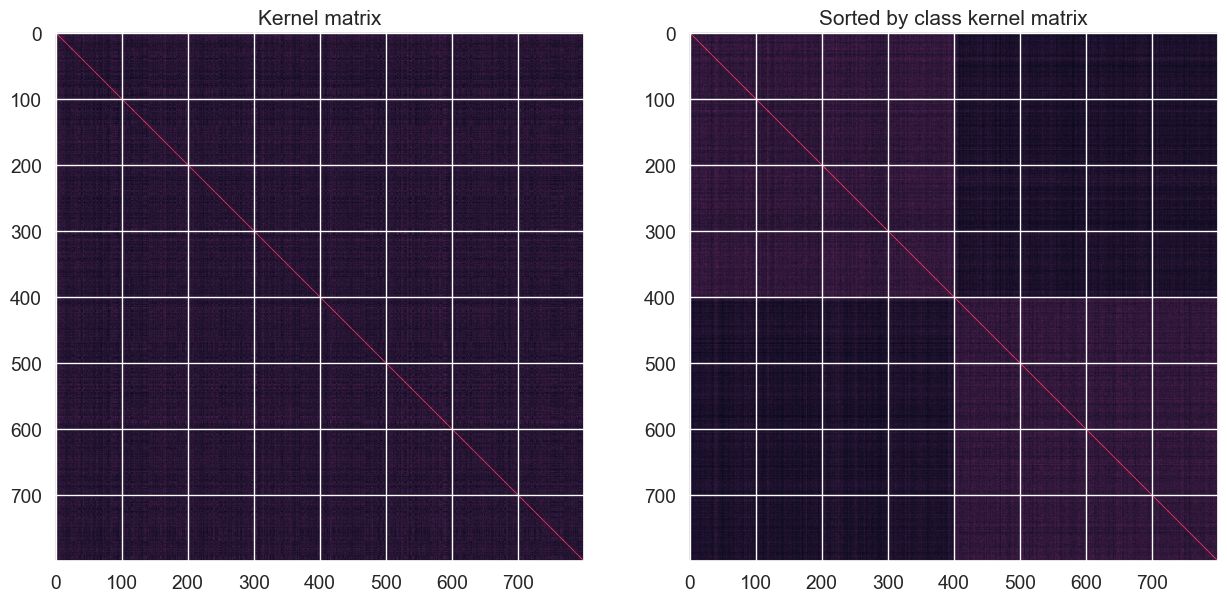

In [15]:

# Gaussian process parameters
kappa = 1.
scale = 5.
theta = [kappa, scale]

K = create_se_kernel(Xtrain, Xtrain, theta)

print(f'Kernel matrix shape: {K.shape}\tMax value {K.max()}')
# check the kernel is positive semidifinite
eigenvalues = linalg.eigvalsh(K)
print(f"All positive eigenvalues: {all(eigenvalues > 0)}\tlowerst {eigenvalues.min()}\n")
# Sort kernel matrix so the classes are grouped
idx = np.argsort(ytrain.squeeze())
K_sort = K[idx][:,idx]

print(f'number of positive examples: {np.sum(ytrain)} \t number of negative examples: {len(ytrain) - np.sum(ytrain)}')

# plot the kernel
figs, axes = plt.subplots(1,2, figsize=(15,10))

axes[0].imshow(K)
axes[0].set_title('Kernel matrix')

axes[1].imshow(K_sort)
axes[1].set_title('Sorted by class kernel matrix')

plt.show()


Define gaussian process model

In [16]:
gp = GaussianProcessModel(Xtrain, ytrain, theta, log_lik_bernoulli)

# predictions
ptrain = predictive(Xtrain, gp)
ptest = predictive(Xtest, gp)  

/Users/Alex/Library/Mobile Documents/com~apple~CloudDocs/DTU/Kandidat/4 semester/quantum-sensing/.venv/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/Alex/Library/Mobile Documents/com~apple~CloudDocs/DTU/Kandidat/4 semester/quantum-sensing/.venv/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/Alex/Library/Mobile Documents/com~apple~CloudDocs/DTU/Kandidat/4 semester/quantum-sensing/.venv/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:77: RuntimeWarning: divide by zero encountered in divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/Alex/Library/Mobile Documents/com~apple~CloudDocs/DTU/Kandidat/4 semester/quantum-sensing/.venv/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:77: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log,    lambda ans, 

LinAlgError: Matrix is not positive definite

Plot predictions probabilities

(391,) (409,)


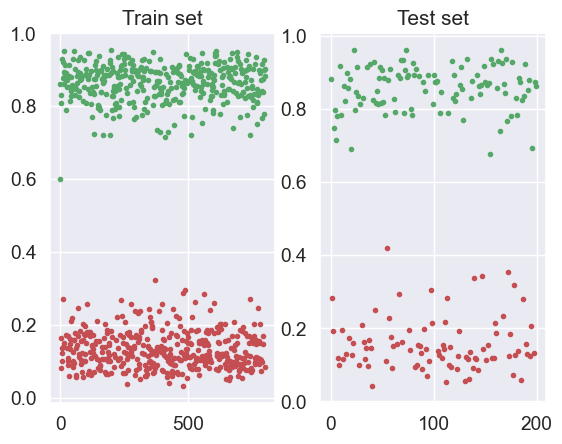

In [ ]:
idx_positive, _ = np.where(ytrain)
idx_negative, _ = np.where(1 - ytrain)

print(idx_positive.shape, idx_negative.shape)
plt.subplot(1,2,1)
plt.plot(idx_positive, ptrain[idx_positive], 'g.')
plt.plot(idx_negative, ptrain[idx_negative],'r.')
plt.title('Train set')


idx_positive, _ = np.where(ytest)
idx_negative, _ = np.where(1 - ytest)

plt.subplot(1,2,2)

plt.plot(idx_positive, ptest[idx_positive], 'g.')
plt.plot(idx_negative, ptest[idx_negative],'r.')
plt.title('Test set')

plt.show()

Make predictions with 0,5 threshold and find the accuracy

In [ ]:
# make predictions
ytrain_hat = 1.0*(ptrain > 0.5)[:,None]
ytest_hat = 1.0*(ptest > 0.5)[:,None]

def compute_err(t, tpred):
    return np.mean(tpred.ravel() == t.ravel()), np.std(tpred.ravel() == t.ravel)/np.sqrt(len(t))

train_err = compute_err(ytrain[:,0], ytrain_hat)
test_err = compute_err(ytest[:,0], ytest_hat)

print(f'Train error: {train_err[0]:.3f} +- {train_err[1]:.3f}')
print(f'Test error: {test_err[0]:.3f} +- {test_err[1]:.3f}')

Train error: 1.000 +- 0.000
Test error: 1.000 +- 0.000


### With fewer observations
The same experiment but with fewer observations.

In [ ]:
K_m = []
error_test = np.zeros((len(M), folds))
error_train = np.zeros((len(M)))

for i, m in enumerate(M):
    print(f"m={m}")
    Xtrain_m = Xtrain[:,:m]
    Xtest_m = Xtest[:,:m]

    # Check kernel 
    K = create_se_kernel(Xtrain_m, Xtrain_m, theta)
    K_m.append(K)

    # train model and make predictions
    gp = GaussianProcessModel(Xtrain_m, ytrain, theta, log_lik_bernoulli)

    # train error
    ptrain = predictive(Xtrain_m, gp)
    ytrain_hat = 1.0*(ptrain > 0.5)
    error_train[i] = compute_err(ytrain[:,0], ytrain_hat)[0] # Note could use std as well


    # test ensamble
    for j, data in enumerate(all_testsets):
        Xtest, ytest, _,_ = data.tensors
        Xtest_m = Xtest.squeeze(1)[:,:m]
        
        ptest = predictive(Xtest_m, gp)
        ytest_hat = 1.0*(ptest > 0.5)
        error_test[i, j] = compute_err(np.array(ytest), ytest_hat)[0]

    



m=90
m=64
m=32
m=24
m=16
m=10
m=6
m=4


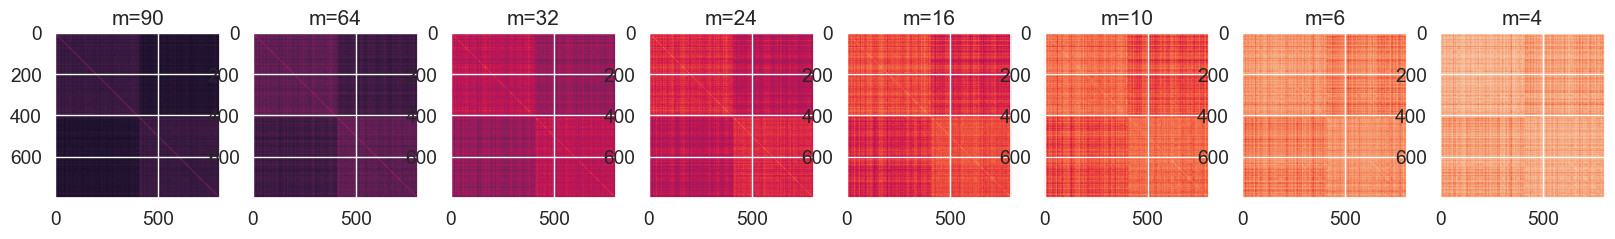

In [ ]:
# plot the kernels
figs, axes = plt.subplots(1,len(M), figsize=(20,5))
for i, K in enumerate(K_m):
    idx = np.argsort(ytrain.squeeze())
    K_sort = K[idx][:,idx]
    axes[i].imshow(K_sort)
    axes[i].set_title(f'm={M[i]}')
plt.show()

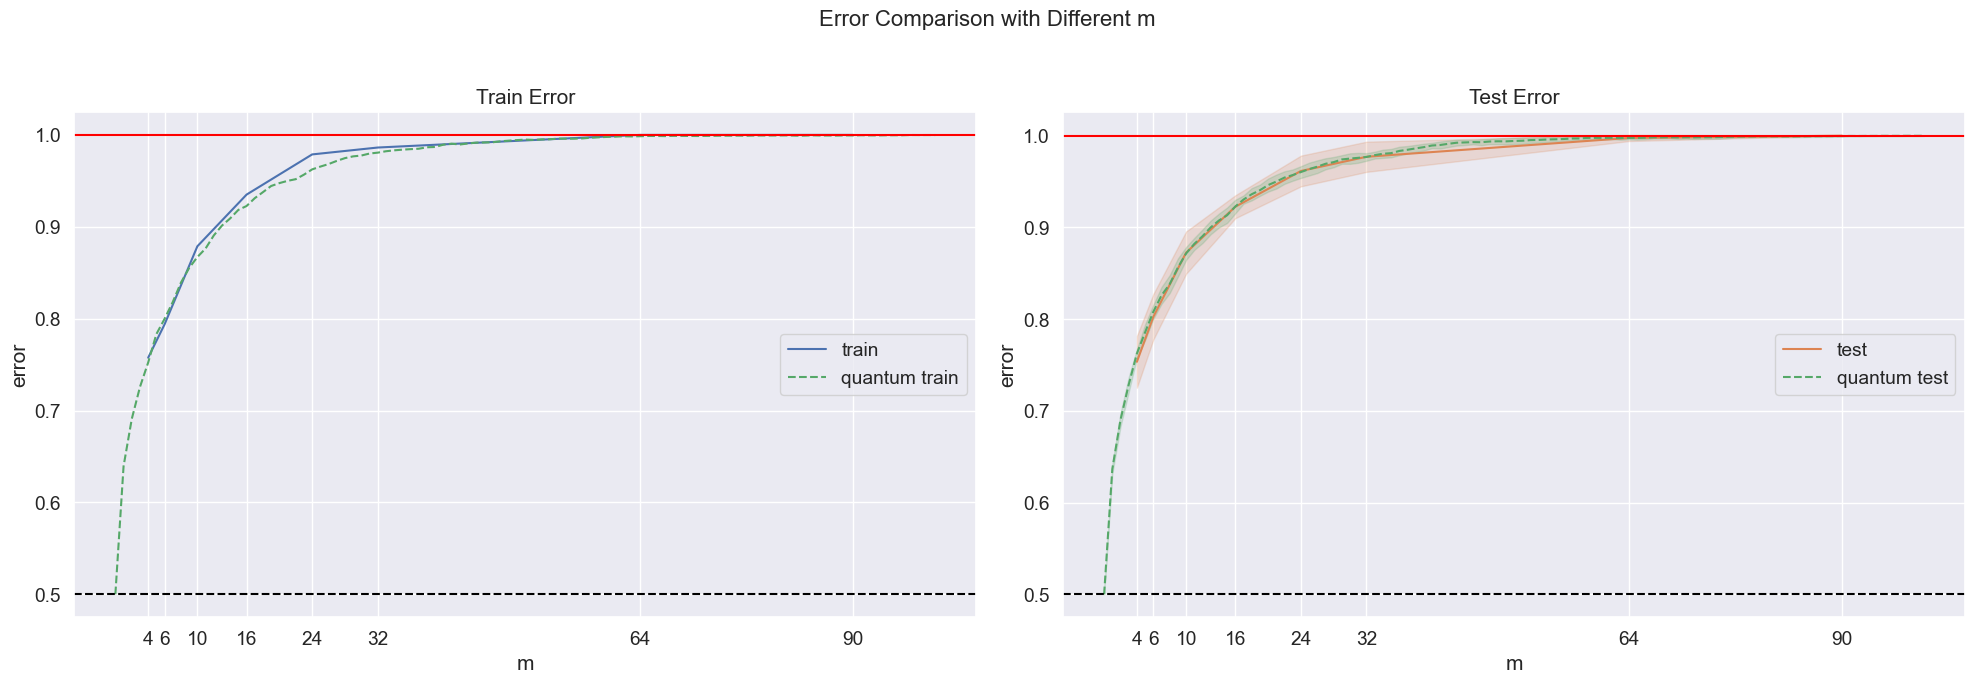

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  # 2 rows, 1 column
fig.suptitle('Error Comparison with Different m', fontsize=16)

# Train Error Plot
axes[0].plot(M, error_train, label='train', color='C0')
axes[0].plot(range(N + 1), train_qprobs, label='quantum train', color='C2', linestyle='--')
axes[0].set_title('Train Error')
axes[0].set_xlabel('m')
axes[0].set_ylabel('error')
axes[0].set_xticks(M)
axes[0].axhline(0.5, color='black', linestyle='--')
axes[0].axhline(1, color='red')
axes[0].legend()

# Test Error Plot
axes[1].plot(M, error_test.mean(axis=1), label='test', color='C1')
axes[1].fill_between(M, 
                     error_test.mean(axis=1) - error_test.std(axis=1), 
                     error_test.mean(axis=1) + error_test.std(axis=1), 
                     alpha=0.2, color='C1')
axes[1].plot(range(N + 1), test_qprobs.mean(axis=1), label='quantum test', color='C2', linestyle='--')
axes[1].fill_between(range(N + 1), 
                     test_qprobs.mean(axis=1) - test_qprobs.std(axis=1), 
                     test_qprobs.mean(axis=1) + test_qprobs.std(axis=1), 
                     alpha=0.2, color='C2')
axes[1].set_title('Test Error')
axes[1].set_xlabel('m')
axes[1].set_ylabel('error')
axes[1].set_xticks(M)
axes[1].axhline(0.5, color='black', linestyle='--')
axes[1].axhline(1, color='red')
axes[1].legend()

# Adjust layout and show/save
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.savefig('figures/Error_Comparison_subplot.png')
plt.show()

Show results with other parameters.

$\kappa$ hvor store hop kan jeg lave
$l$ range for meausurement records

### Compare the models


NameError: name 'mean_test_acc' is not defined

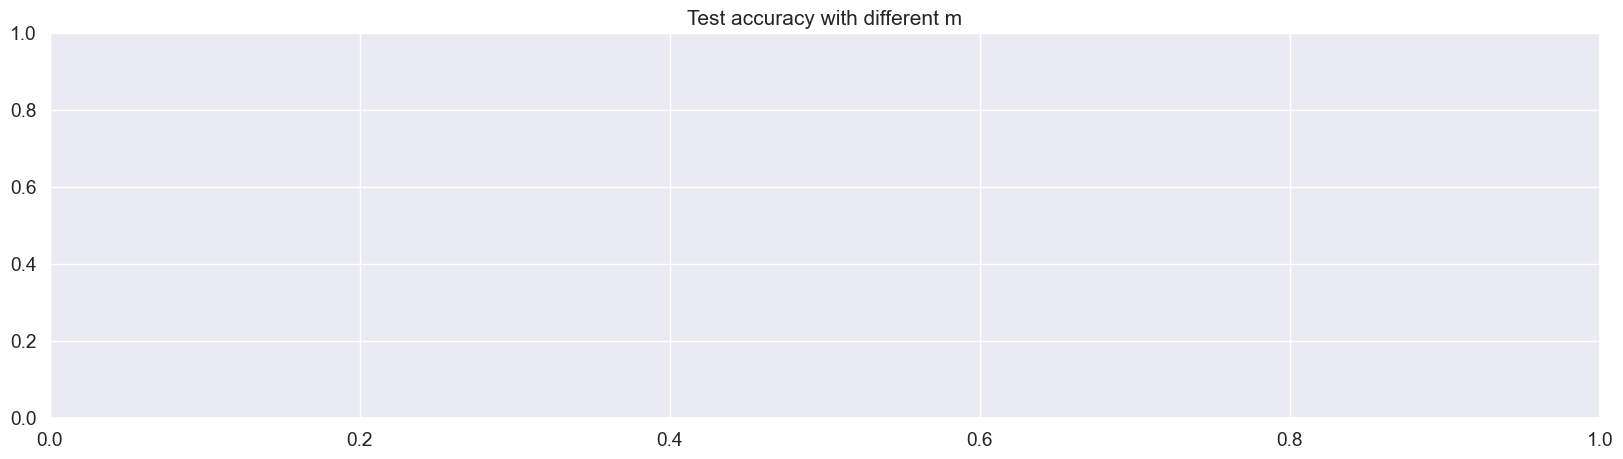

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Test accuracy with different m')
# CNN
plt.plot(M, mean_test_acc, label='CNN', color='C0')
plt.fill_between(M, mean_test_acc - test_acc.std(axis=1), mean_test_acc + test_acc.std(axis=1), alpha=0.2, color='C0')
# GP
plt.plot(M, error_test.mean(axis=1), label='GP', color='C1')
plt.fill_between(M, 
                     error_test.mean(axis=1) - error_test.std(axis=1), 
                     error_test.mean(axis=1) + error_test.std(axis=1), 
                     alpha=0.2, color='C1')
plt.plot(range(N + 1), test_qprobs.mean(axis=1), label='quantum', color='C2', linestyle='--')
plt.fill_between(range(N + 1), 
                     test_qprobs.mean(axis=1) - test_qprobs.std(axis=1), 
                     test_qprobs.mean(axis=1) + test_qprobs.std(axis=1), 
                     alpha=0.2, color='C2')
plt.xlabel('m')
plt.ylabel('test accuracy')
plt.ylim(0.4,1.1)
plt.xticks(M)
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(1, color='red')
plt.legend()
plt.show()

# Plot with deviation from test_qprobs
plt.figure(figsize=(20,5))
plt.plot(M, mean_test_acc - test_qprobs[M,:].mean(axis=1), label='CNN', color='C0')
plt.fill_between(M,
                    mean_test_acc - test_qprobs[M,:].mean(axis=1) - test_acc.std(axis=1),
                    mean_test_acc - test_qprobs[M,:].mean(axis=1) + test_acc.std(axis=1),
                    alpha=0.2, color='C0')
plt.plot(M, error_test.mean(axis=1) - test_qprobs[M,:].mean(axis=1), label='GP', color='C1')
plt.fill_between(M,
                    error_test.mean(axis=1) - test_qprobs[M,:].mean(axis=1) - error_test.std(axis=1),
                    error_test.mean(axis=1) - test_qprobs[M,:].mean(axis=1) + error_test.std(axis=1),
                    alpha=0.2, color='C1')
plt.xlabel('m')
plt.ylabel('test accuracy - quantum test accuracy')
plt.xticks(M)
plt.axhline(0, color='C2', linestyle='--', legend='quantum')
plt.legend()
plt.ylim(-0.1, 0.1)
plt.show()


## Noisy data
add a defect meter that sometimes does not do the measurement. There is 2 potential ways to do this:
* Randomly remove some of the measurements
* Randomly remove clusters of measurements, the measurement that is remove will therefore be neighbors.


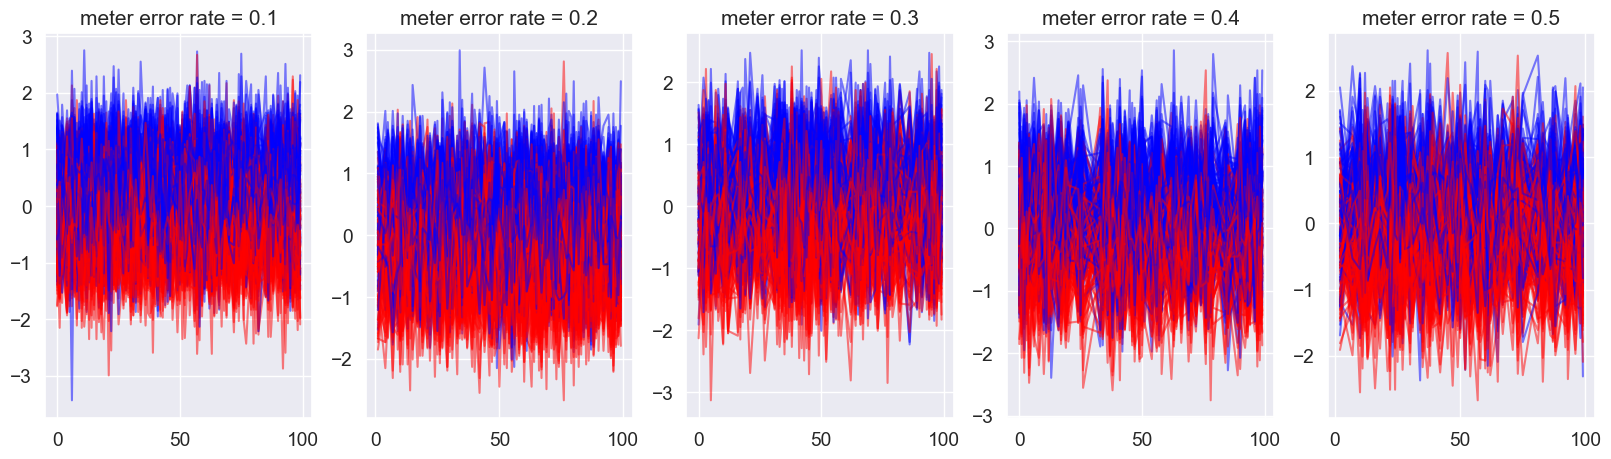

In [45]:
meter_errors = [0.1, 0.2, 0.3, 0.4, 0.5]

# create datasets with meter errors
all_testsets = [create_datasets_sim(200,1, N=N, g=g, a0=a0, meter_error=m) for m in meter_errors]


# Visualize the data
fig, axes = plt.subplots(1, len(meter_errors), figsize=(20, 5))
for i, data in enumerate(all_testsets):

    T = data[1]
    Xtest, ytest, _,_ = data[0].tensors
    Xtest = np.array(Xtest.squeeze(1))
    ytest = np.array(ytest.unsqueeze(1))

    axes[i].set_title(f'meter error rate = {meter_errors[i]}')
    for j in range(Xtest.shape[0]):
        if ytest[j] == 0:
            axes[i].plot(np.sort(T), np.cumsum(Xtest[j]), color='red', alpha=0.5)
        else:
            axes[i].plot(np.sort(T), np.cumsum(Xtest[j]), color='blue', alpha=0.5)
    
plt.show()


Andre eksperimenter:
* Fjern en andel af meausrements
    * Tilfældige
    * fjern i clusters
* forsøg med HMM antaget kontalt state

In [ ]:
test_qprobs[M,:].mean(axis=1)

array([0.99962524, 0.99762758, 0.97678739, 0.96032675, 0.92273757,
       0.87154111, 0.80793957, 0.76248265])

In [41]:
np.sort(T)

array([ 2,  5,  8, 10, 11, 12, 13, 14, 16, 18, 21, 24, 25, 26, 29, 31, 32,
       34, 35, 39, 41, 42, 43, 45, 46, 48, 50, 52, 54, 55, 56, 60, 61, 65,
       67, 70, 72, 75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 88, 90, 92])